In [68]:
#!/usr/bin/env python3

%reload_ext autoreload
%autoreload 2

# Maths
import numpy as np

# PCovR utilities
from regression import LR, KRR, SparseKRR, PCovR, KPCovR, SparseKPCovR
from decomposition import PCA, KPCA, SparseKPCA
from kernels import linear_kernel, gaussian_kernel, center_kernel
from tools import FPS, split

# ASE
from ase.io import read, write

# SOAP
from rascal.representations import SphericalInvariants as SOAP

# Scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the plots look nicer
plot_parameters = {
    'lines.linewidth': 1.0,
    'lines.markersize': 2,
    'patch.linewidth': 1.0,
    'hatch.linewidth': 1.0,
    'axes.linewidth': 1.0,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'xtick.major.size': 4.0,
    'xtick.minor.size': 2.0,
    'xtick.major.pad': 5.0,
    'xtick.minor.pad': 5.0,
    'ytick.left': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
    'ytick.major.size': 4.0,
    'ytick.minor.size': 2.0,
    'ytick.major.pad': 5.0,
    'ytick.minor.pad': 5.0   
}

for pp in plot_parameters.keys():
    mpl.rcParams[pp] = plot_parameters[pp]

In [69]:
# Read xyz files
s = read('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/datasets/CSD-1000R.xyz', index=':5')

# Extract chemical shifts
cs = []
for ss in s:
    ss.wrap()
    cs.append(ss.arrays['CS_local'])

In [70]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

In [71]:
soap_rep = soap.transform(s)

In [72]:
X = soap_rep.get_features(soap)

In [73]:
n_FPS = 200
idxs, d = FPS(X.T, n_FPS)
X = X[:, idxs]

In [74]:
# Center the data
Y = np.concatenate(cs)
X -= np.mean(X, axis=0)
Y -= np.mean(Y, axis=0)
print(X.shape)
print(Y.shape)

(720, 200)
(720,)


# PCA

In [75]:
pca = PCA(n_pca=None)
pca.fit(X)
Xpca = pca.transform(X)

Xrpca = pca.inverse_transform(X)

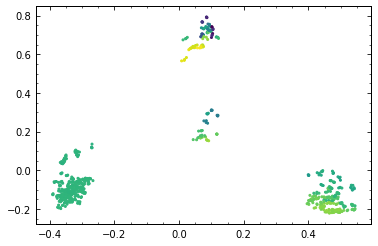

In [76]:
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=Y, cmap='viridis')
plt.show()

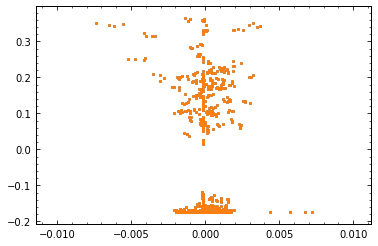

In [77]:
plt.scatter(Xrpca[:, 0], Xrpca[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# Linear Regression

In [78]:
lr = LR()
lr.fit(X, Y)
Yplr = lr.transform(X)

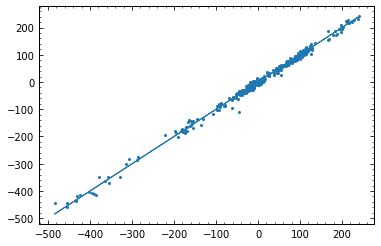

In [79]:
plt.scatter(Y, Yplr)
plt.plot(Y, Y, linestyle='-')
plt.show()

# KPCA

In [80]:
kpca = KPCA(n_kpca=None)
K = gaussian_kernel(X, X)
Kc = center_kernel(K)
kpca.fit(Kc)
Xkpca = kpca.transform(Kc)

KTT = gaussian_kernel(Xkpca, Xkpca)
KTTc = center_kernel(KTT)
KXT = gaussian_kernel(Xkpca, Xkpca)
KXTc = center_kernel(KXT, K_ref=KTT)
Xrkpca = kpca.inverse_transform(KTTc, KXTc, X)

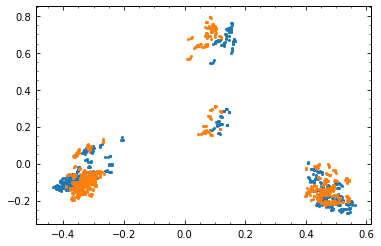

In [81]:
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.show()

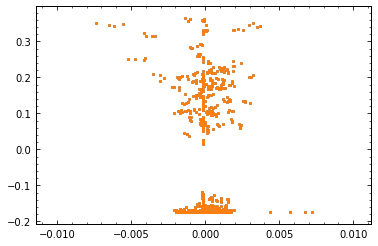

In [82]:
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# KRR

In [83]:
krr = KRR()
krr.fit(Kc, Y)
Ypkrr = krr.transform(Kc)

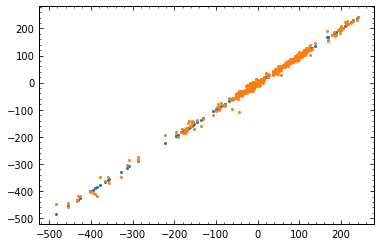

In [84]:
plt.scatter(Y, Ypkrr)
plt.scatter(Y, Yplr)
plt.show()

# Sparse KPCA

In [85]:
idxs, _ = FPS(X, 200)

In [86]:
Xs = X[idxs, :]
KNM = gaussian_kernel(X, Xs)
KMM = gaussian_kernel(Xs, Xs)

KMMc = center_kernel(KMM)
KNMc = center_kernel(KNM, K_ref=KMM)

In [87]:
kpca_sparse = SparseKPCA(n_kpca=None)
kpca_sparse.fit(KNMc, KMMc)
Xskpca = kpca_sparse.transform(KNMc)

Xskpcas = Xskpca[idxs, :]
tKMM = gaussian_kernel(Xskpcas, Xskpcas)
tKMMc = center_kernel(KMM)
KTM = gaussian_kernel(Xskpca, Xskpcas)
KTMc = center_kernel(KTM, K_ref=KMM)
KXM = gaussian_kernel(Xskpca, Xskpcas)
KXMc = center_kernel(KXM, K_ref=KMM)
Xrskpca = kpca_sparse.inverse_transform(KTMc, tKMMc, KXMc, X, sigma=1E-5)

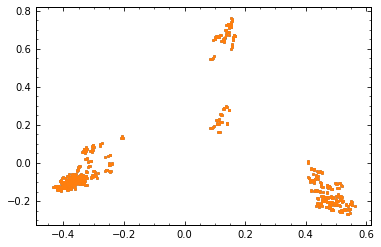

In [88]:
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

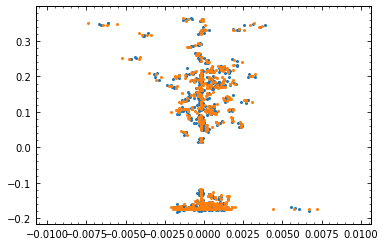

In [89]:
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# Sparse KRR

In [90]:
skrr = SparseKRR(sigma=1E-5)
skrr.fit(KNMc, KMMc, Y)
Ypskrr = skrr.transform(KNMc)

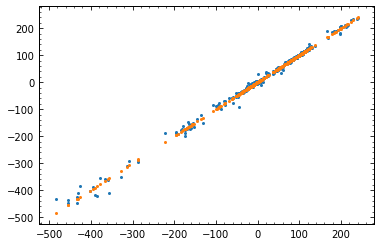

In [91]:
plt.scatter(Y, Ypskrr)
plt.scatter(Y, Ypkrr)
plt.show()

# PCovR

In [92]:
pcovr0 = PCovR(alpha=0.0, n_pca=None)
pcovr1 = PCovR(alpha=1.0, n_pca=None)

In [93]:
pcovr0.fit_feature_space(X, Y)
pcovr1.fit_feature_space(X, Y)

In [94]:
Xp = pcovr1.transform_X(X)
Xr = pcovr1.inverse_transform_X(X)
Yp = pcovr0.transform_Y(X)

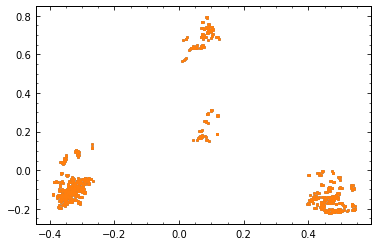

In [95]:
plt.scatter(Xp[:, 0], Xp[:, 1])
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.show()

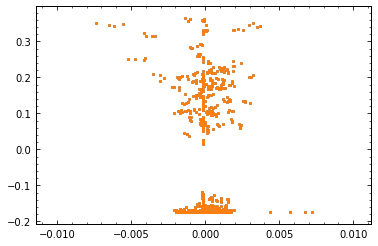

In [96]:
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

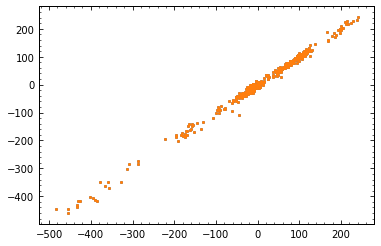

In [97]:
plt.scatter(Y, Yp)
plt.scatter(Y, Yplr)
plt.show()

# Kernel PCovR

In [98]:
kpcovr0 = KPCovR(alpha=0.0, n_kpca=None)
kpcovr1 = KPCovR(alpha=1.0, n_kpca=None)

In [99]:
kpcovr0.fit(Kc, Y)
kpcovr1.fit(Kc, Y, X=X)

In [100]:
Xkp = kpcovr1.transform_K(Kc)
Krkp = kpcovr1.inverse_transform_K(Kc)
Xrkp = kpcovr1.inverse_transform_X(Kc)
Ykp = kpcovr0.transform_Y(Kc)

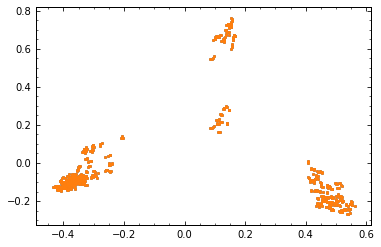

In [101]:
plt.scatter(Xkp[:, 0], Xkp[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

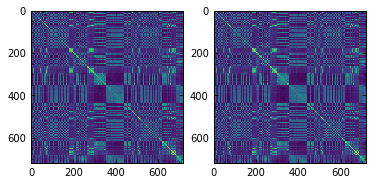

2.981521575890577e-13


In [102]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(Kc)
axs[1].imshow(Krkp)
plt.show()
print(np.linalg.norm(Kc-Krkp))

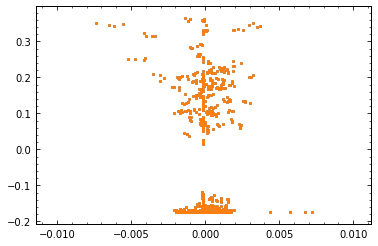

In [103]:
plt.scatter(Xrkp[:, 0], Xrkp[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

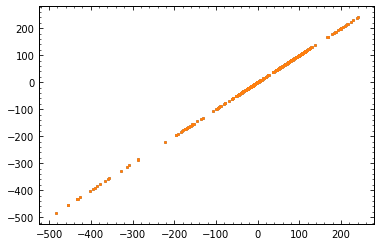

In [104]:
plt.scatter(Y, Ykp)
plt.scatter(Y, Ypkrr)
plt.show()

# Sparse KPCovR

In [112]:
skpcovr0 = SparseKPCovR(alpha=0.0, n_kpca=None, sigma=1E-5)
skpcovr1 = SparseKPCovR(alpha=1.0, n_kpca=None, sigma=1E-5)

In [114]:
skpcovr0.fit(KNMc, KMMc, Y)
skpcovr1.fit(KNMc, KMMc, Y, X)

In [107]:
Xskp = skpcovr1.transform_K(KNMc)
Krskp = skpcovr1.inverse_transform_K(KNMc)
Xrskp = skpcovr1.inverse_transform_X(KNMc)
Yskp = skpcovr0.transform_Y(KNMc)

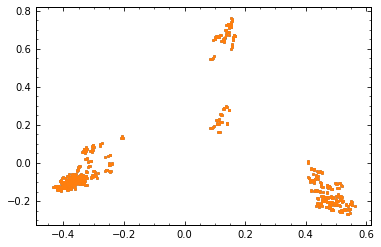

In [108]:
plt.scatter(Xskp[:, 0], Xskp[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

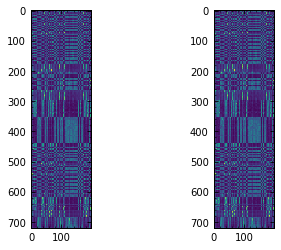

6.872467991458892e-08


In [109]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(KNMc)
axs[1].imshow(Krskp)
plt.show()
print(np.linalg.norm(KNMc-Krskp))

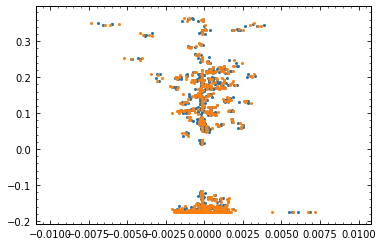

In [110]:
plt.scatter(Xrskp[:, 0], Xrskp[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

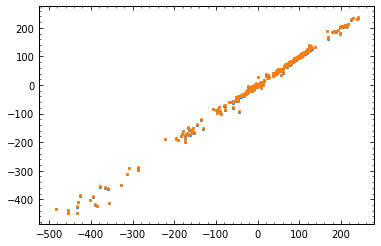

In [111]:
plt.scatter(Y, Yskp)
plt.scatter(Y, Ypskrr)
plt.show()